# Fraud Detection Project

The goal of this project is to find a way to detect car insurance frauds using, in addition to some more standard features, a score of the entities obtained with a network analysis of the parties involved in a car accident.

Car insurance frauds detection is very important in the insurance business: their correct detection translates directly in money savings. Unfortunately to do so is often required a careful audit of the claims, in this sense having a reliable automated system capable of highlighting the most suspicious-looking claims may lead to an optimization of the auditing process and ultimately to an economic gain.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Claims Data

I start by importing the claims' data for the years between 2010 and 2017. Here's a brief description of the columns:

- claim_code: unique identifier of the claim
- black_box: whether the insured car has a black box on it
- black_box_active: whether the black box is operating (-1 if not applicable)
- crash: whether the black box detected a crash (-1 if not applicable)
- filing_date: date in which the insurance company has been made aware of the claim
- accident_date: car accident's date
- policy_start_date: date from which the insurance policy is operative
- policy_end_date: date until which the insurance policy is operative
- accident_province: province of the accident
- claim_profile: claim profile (a categorization of the type of accident)
- n_vehicles: number of vehicles involved
- n_people: number of people involved

In [2]:
claims = pd.read_csv('../data/raw/claims.csv', sep=';', na_values='', keep_default_na=False)
claims['filing_date'] = pd.to_datetime(claims['filing_date'])
claims['accident_date'] = pd.to_datetime(claims['accident_date'])
claims['policy_start_date'] = pd.to_datetime(claims['policy_start_date'])
claims['policy_end_date'] = pd.to_datetime(claims['policy_end_date'])

In [3]:
claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124042 entries, 0 to 124041
Data columns (total 12 columns):
claim_code           124042 non-null int64
black_box            124042 non-null int64
black_box_active     124042 non-null int64
crash                124042 non-null int64
filing_date          124042 non-null datetime64[ns]
accident_date        124042 non-null datetime64[ns]
policy_start_date    124042 non-null datetime64[ns]
policy_end_date      124042 non-null datetime64[ns]
accident_province    124042 non-null object
claim_profile        117303 non-null object
n_vehicles           124042 non-null int64
n_people             124042 non-null int64
dtypes: datetime64[ns](4), int64(6), object(2)
memory usage: 11.4+ MB


In [4]:
claims.dropna(inplace=True)

Lets's take a look at the distribution of claims by week, province and profile:

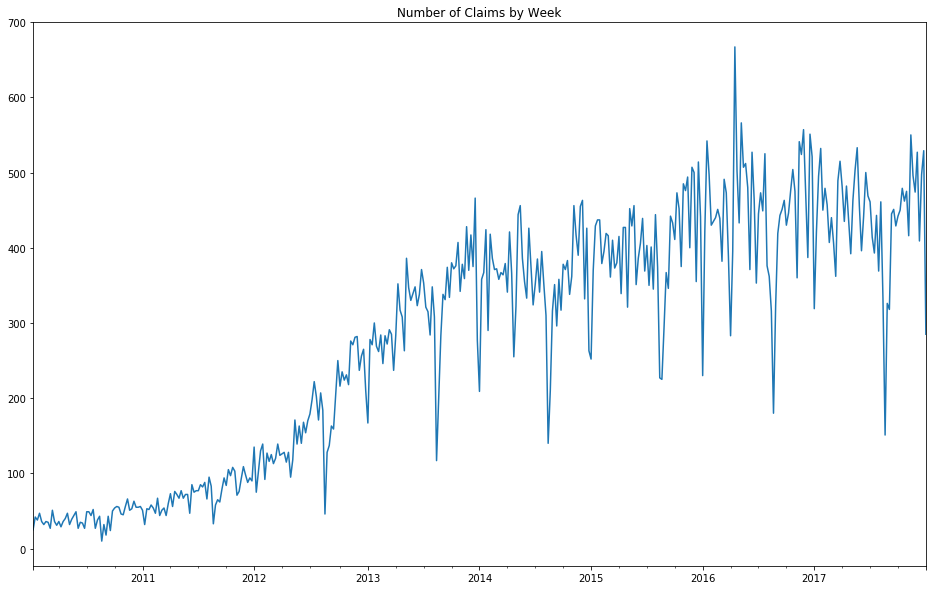

In [5]:
claims['filing_date'].value_counts().resample('W').sum().plot(figsize=(16, 10))
plt.title('Number of Claims by Week');

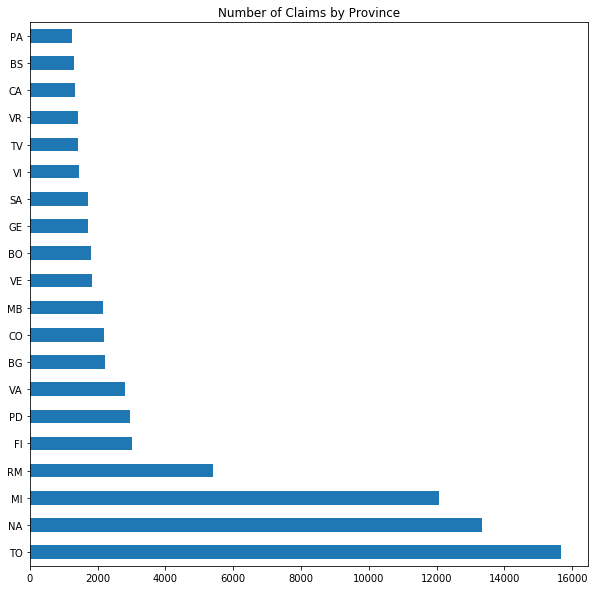

In [6]:
claims['accident_province'].value_counts().sort_values(ascending=False).head(20).plot.barh(figsize=(10, 10))
plt.title('Number of Claims by Province');

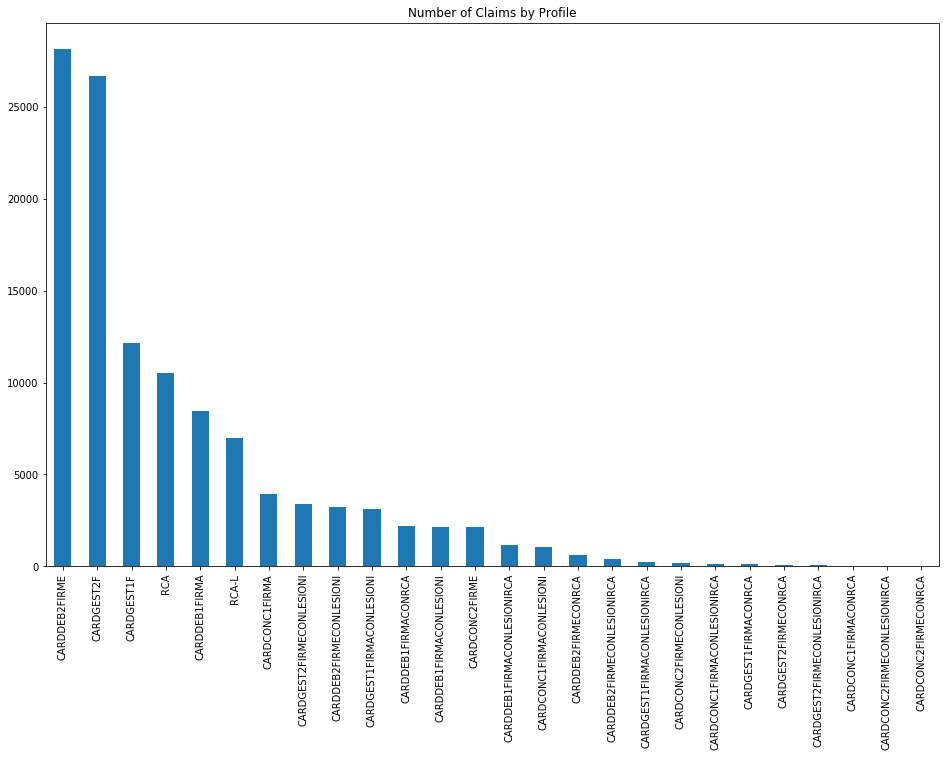

In [7]:
claims['claim_profile'].value_counts().plot.bar(figsize=(16, 10))
plt.title('Number of Claims by Profile');

There are some claim profiles that don't have a lot of occurrences in the dataset, so I'm going to group them according to some common features such as:

- card: claims for which a statement has been compiled by one or more of the involved parties
- injury: claims in which a person got injured
- rca: claims involving at least two vehicles
- n_signatures: number of signatures on the statement

In [8]:
claims['card'] = claims['claim_profile'].apply(lambda x: 1 if 'CARD' in x else 0)
claims['injury'] = claims['claim_profile'].apply(lambda x: 1 if 'L' in x else 0)
claims['rca'] = claims['claim_profile'].apply(lambda x: 1 if 'RCA' in x else 0)
claims['n_signatures'] = claims['claim_profile'].apply(lambda x: 1 if '1' in x else 2 if '2' in x else 0)

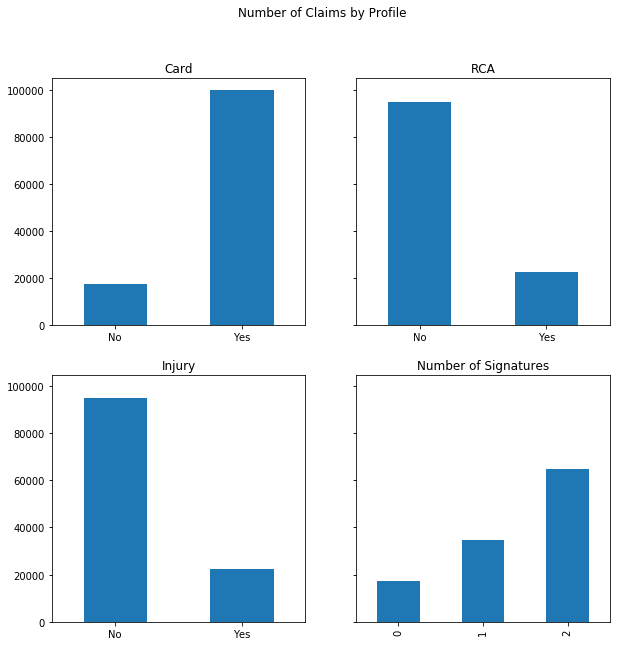

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
claims['card'].value_counts().sort_index().plot.bar(ax=ax[0, 0])
ax[0, 0].set_title('Card')
ax[0, 0].set_xticklabels(['No', 'Yes'], rotation=0)
claims['rca'].value_counts().sort_index().plot.bar(ax=ax[0, 1])
ax[0, 1].set_title('RCA')
ax[0, 1].set_xticklabels(['No', 'Yes'], rotation=0)
claims['injury'].value_counts().sort_index().plot.bar(ax=ax[1, 0])
ax[1, 0].set_title('Injury')
ax[1, 0].set_xticklabels(['No', 'Yes'], rotation=0)
claims['n_signatures'].value_counts().sort_index().plot.bar(ax=ax[1, 1])
ax[1, 1].set_title('Number of Signatures')
plt.suptitle('Number of Claims by Profile');

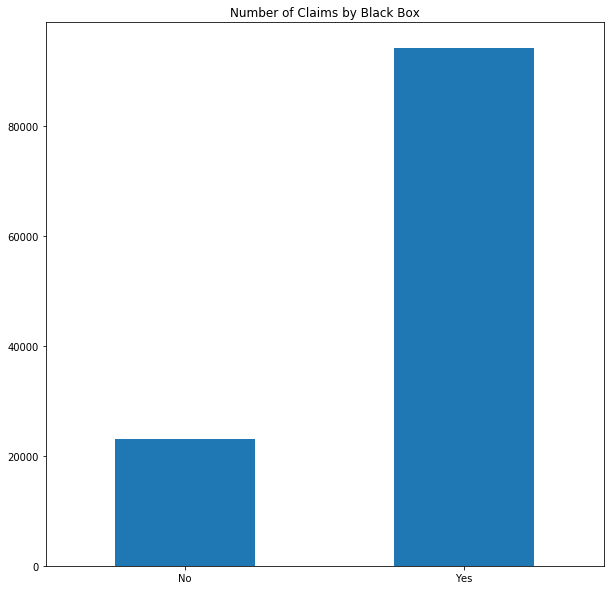

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
claims['black_box'].value_counts().sort_index().plot.bar(ax=ax)
ax.set_xticklabels(['No', 'Yes'], rotation=0)
plt.title('Number of Claims by Black Box');

As you can see there is a growth in the number of claims in the years, which is due to the increase of the number of insured vehicles.

The distribution among the provinces reflects in part the distribution of the italian population and in part the market penetration of the company in the country.

Finally, the vast majority of the claims involves a car with the black box installed.

## Provisions

These are the initial provisions for the claim, e.g. the money the insurance company thinks could be used toward the claim resolution (both incoming and outcoming):

- incoming_forfait_provision: incoming money, this is a standard amount and its payment is regulated by a third party and not between insurance companies
- incoming_provision: incoming money, its payment is regulated between insurance companies
- outgoing_forfait_provision: outgoing money, this is a standard amount and its payment is regulated by a third party and not between insurance companies
- outgoing_provision: outgoing money, its payment is regulated between insurance companies

I'm going to sum up incoming and outcoming money to see the total amounts for each direction.

In [11]:
provisions = pd.read_csv('../data/raw/provisions.csv', sep=';')
provisions['total_outgoing_provision'] = provisions['outgoing_forfait_provision'] + provisions['outgoing_provision']
provisions['total_incoming_provision'] = provisions['incoming_forfait_provision'] + provisions['incoming_provision']
# provisions['total_provisions'] = provisions['total_outgoing_provision'] + provisions['total_incoming_provision']

In [12]:
provisions.describe().T

,count,mean,std,min,25%,50%,75%,max
claim_code,123727.0,2.014508e+15,1.971116e+12,2.010010e+15,2.013010e+15,2.015010e+15,2.016010e+15,2.017079e+15
incoming_forfait_provision,123727.0,8.568784e+02,1.252821e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.810000e+03,1.485260e+05
incoming_provision,123727.0,3.232924e-02,1.137176e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+03
outgoing_forfait_provision,123727.0,8.551736e+02,1.159150e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.810000e+03,3.182000e+04
outgoing_provision,123727.0,1.507797e+03,3.489154e+03,0.000000e+00,0.000000e+00,1.700000e+03,1.700000e+03,7.500000e+05
total_outgoing_provision,123727.0,2.362971e+03,3.317828e+03,0.000000e+00,1.700000e+03,1.700000e+03,1.930000e+03,7.500000e+05
total_incoming_provision,123727.0,8.569107e+02,1.252850e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.810000e+03,1.485260e+05


In [13]:
provisions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123727 entries, 0 to 123726
Data columns (total 7 columns):
claim_code                    123727 non-null int64
incoming_forfait_provision    123727 non-null float64
incoming_provision            123727 non-null float64
outgoing_forfait_provision    123727 non-null float64
outgoing_provision            123727 non-null float64
total_outgoing_provision      123727 non-null float64
total_incoming_provision      123727 non-null float64
dtypes: float64(6), int64(1)
memory usage: 6.6 MB


In [14]:
print(sum(provisions['total_outgoing_provision'] >= 3*provisions['total_outgoing_provision'].median()))

9139


There are a lot of outliers for the outgoing money, so I'm going to cap it in order to be able to visualize it:

In [15]:
provisions['capped_outgoing_provision'] = provisions['total_outgoing_provision'].apply(lambda x: 10000 if x>=10000 else x)

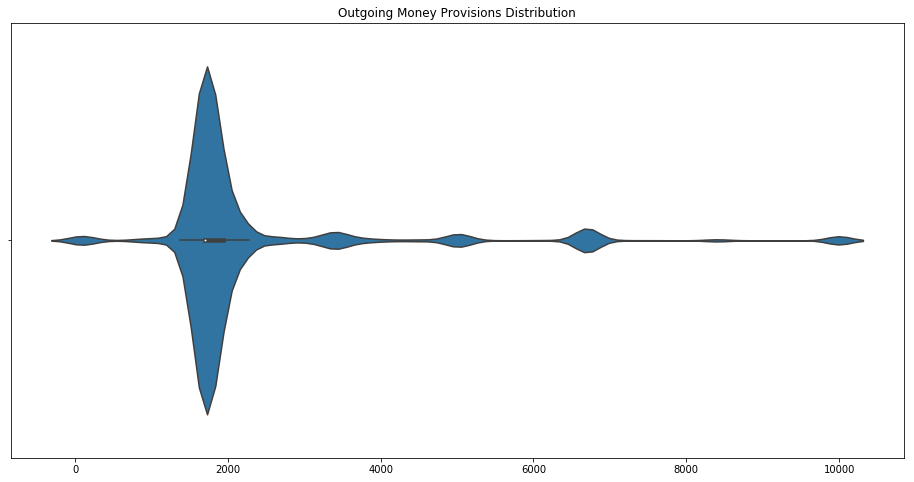

In [16]:
plt.figure(figsize=(16, 8))
sns.violinplot(provisions['capped_outgoing_provision'])
plt.xlabel('')
plt.title('Outgoing Money Provisions Distribution');

## Anti-fraud Assessments

Finally, I'm going to import the fraud assessments made by the insurance company and by ANIA, the national insurance association. The insurance company assigns a score between 0 and 100 to the claims, while ANIA evaluates the claims as either fraudolent, possibly fraudolent or not fraudolent.

In [17]:
assessments = pd.read_csv('../data/raw/antifraud_assessments.csv', sep=';')

In [18]:
assessments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93661 entries, 0 to 93660
Data columns (total 4 columns):
claim_code          93661 non-null int64
company_score       93589 non-null float64
ivass_score         93589 non-null float64
fraud_evaluation    2835 non-null object
dtypes: float64(2), int64(1), object(1)
memory usage: 2.9+ MB


As one can imagine, most of the scores are very low:

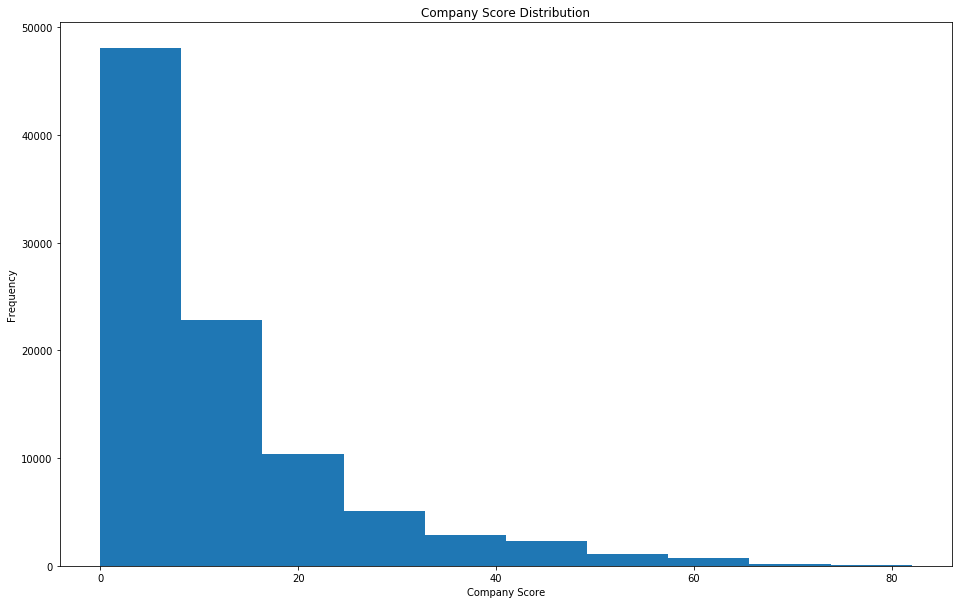

In [19]:
assessments['company_score'].plot.hist(figsize=(16, 10))
plt.xlabel('Company Score')
plt.title('Company Score Distribution');
# plt.savefig('../reports/figures/score_distr.png')

Now I'll be evaluating a claim as fraudolent if it's score is over 50 and I'm going to compare the distribution of fraudolent claims among some of the variables in the previous datasets:

In [20]:
claims_ass = claims.merge(assessments, how='inner', left_on='claim_code', right_on='claim_code')
claims_ass['fraud'] = claims_ass['company_score'].apply(lambda x: 1 if x > 50.0 else 0)

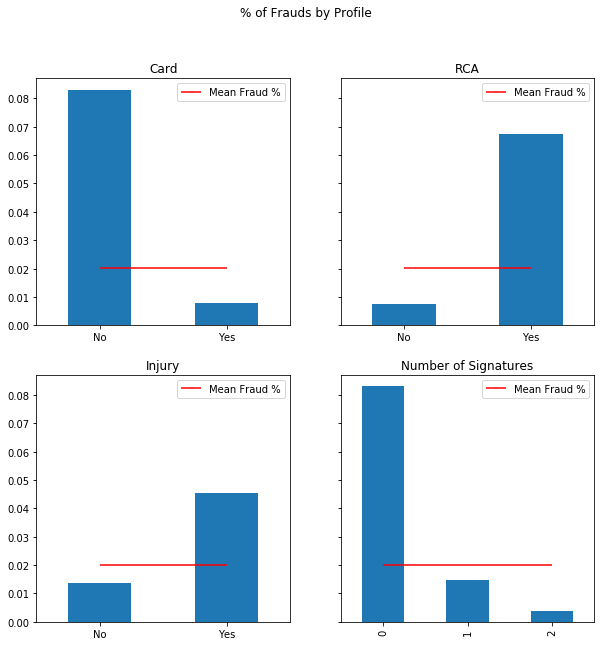

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey=True)

claims_ass.groupby('card')['fraud'].mean().sort_index().plot.bar(label='', ax=ax[0, 0])
ax[0, 0].hlines(claims_ass['fraud'].mean(), 0, 1, colors='r', label='Mean Fraud %')
ax[0, 0].set_xlabel('')
ax[0, 0].set_title('Card')
ax[0, 0].legend(loc='upper right')
ax[0, 0].set_xticklabels(['No', 'Yes'], rotation=0)

claims_ass.groupby('rca')['fraud'].mean().sort_index().plot.bar(label='', ax=ax[0, 1])
ax[0, 1].hlines(claims_ass['fraud'].mean(), 0, 1, colors='r', label='Mean Fraud %')
ax[0, 1].set_xlabel('')
ax[0, 1].set_title('RCA')
ax[0, 1].legend(loc='upper right')
ax[0, 1].set_xticklabels(['No', 'Yes'], rotation=0)

claims_ass.groupby('injury')['fraud'].mean().sort_index().plot.bar(label='', ax=ax[1, 0])
ax[1, 0].hlines(claims_ass['fraud'].mean(), 0, 1, colors='r', label='Mean Fraud %')
ax[1, 0].set_xlabel('')
ax[1, 0].set_title('Injury')
ax[1, 0].legend(loc='upper right')
ax[1, 0].set_xticklabels(['No', 'Yes'], rotation=0)

claims_ass.groupby('n_signatures')['fraud'].mean().sort_index().plot.bar(label='', ax=ax[1, 1])
ax[1, 1].hlines(claims_ass['fraud'].mean(), 0, 2, colors='r', label='Mean Fraud %')
ax[1, 1].set_xlabel('')
ax[1, 1].set_title('Number of Signatures')
ax[1, 1].legend(loc='upper right')

plt.suptitle('% of Frauds by Profile');
# plt.savefig('../reports/figures/fraud_profile.png')

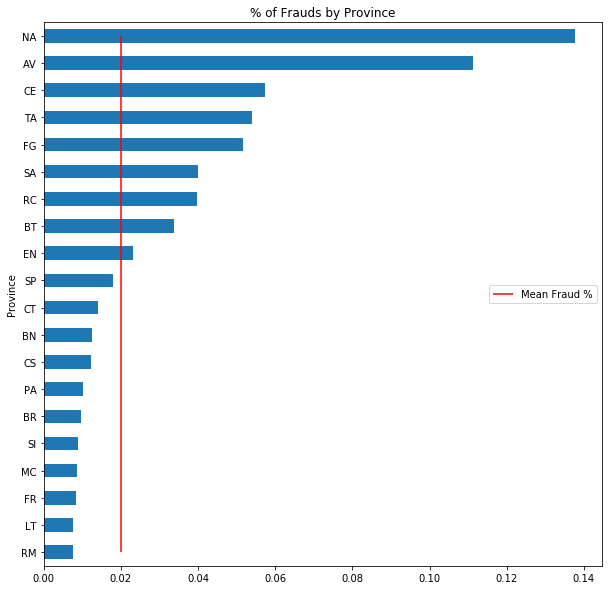

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
claims_ass.groupby('accident_province')['fraud'].mean().sort_values().tail(20).plot.barh(label='', ax=ax)
ax = plt.vlines(claims_ass['fraud'].mean(), 0, 19, colors='r', label='Mean Fraud %')
plt.legend(loc='center right')
plt.ylabel('Province')
plt.title('% of Frauds by Province');
# plt.savefig('../reports/figures/fraud_province.png')

There are for sure some claim profiles and provinces where the occurrences of frauds is higher than others, but using the province might introduce some bias in my model so I'm going to create two version of it, one with and one without the province.

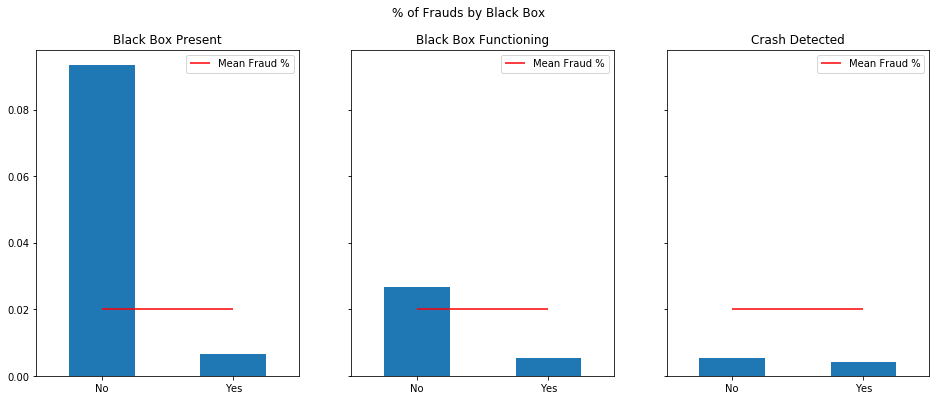

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(16, 6), sharey=True)

claims_ass.groupby('black_box')['fraud'].mean().sort_index().plot.bar(label='', ax=ax[0])
ax[0].hlines(claims_ass['fraud'].mean(), 0, 1, colors='r', label='Mean Fraud %')
ax[0].set_xlabel('')
ax[0].legend(loc='upper right')
ax[0].set_xticklabels(['No', 'Yes'], rotation=0)
ax[0].set_title('Black Box Present')

claims_ass.loc[claims_ass['black_box']==1].groupby('black_box_active')['fraud'].mean().sort_index().plot.bar(label='', ax=ax[1])
ax[1].hlines(claims_ass['fraud'].mean(), 0, 1, colors='r', label='Mean Fraud %')
ax[1].set_xlabel('')
ax[1].legend(loc='upper right')
ax[1].set_xticklabels(['No', 'Yes'], rotation=0)
ax[1].set_title('Black Box Functioning')

claims_ass.loc[claims_ass['black_box_active']==1].groupby('crash')['fraud'].mean().sort_index().plot.bar(label='', ax=ax[2])
ax[2].hlines(claims_ass['fraud'].mean(), 0, 1, colors='r', label='Mean Fraud %')
ax[2].set_xlabel('')
ax[2].legend(loc='upper right')
ax[2].set_xticklabels(['No', 'Yes'], rotation=0)
ax[2].set_title('Crash Detected')

plt.suptitle('% of Frauds by Black Box');
# plt.savefig('../reports/figures/fraud_blackbox.png')

There seems only to be a significative difference in fraud percentage depending on whether the box is present.

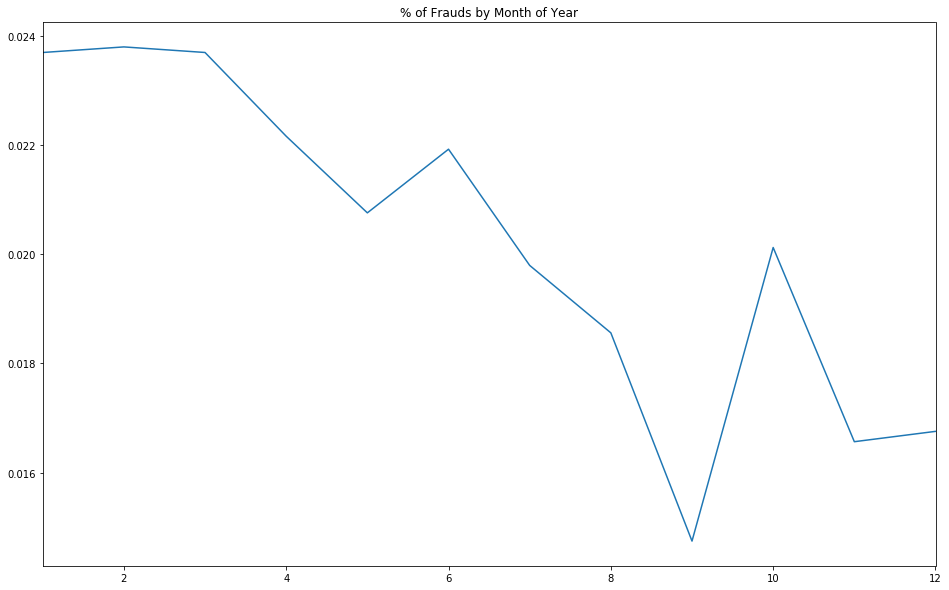

In [24]:
claims_ass['filing_month'] = claims_ass['filing_date'].dt.month
claims_ass.groupby('filing_month')['fraud'].mean().plot(figsize=(16, 10))
plt.xlabel('')
plt.title('% of Frauds by Month of Year');
# plt.savefig('../reports/figures/fraud_month.png')

There seems to be a slight difference in the percentage of frauds between the months in which the claim is filed.

Let's also try to see if the time between the accident and the filing of the claim is indicative of a fraudolent behaviour:

In [25]:
claims_ass['filing_diff'] = (claims_ass['filing_date'] - claims_ass['accident_date']).dt.days
claims_ass['start_diff'] = (claims_ass['filing_date'] - claims_ass['policy_start_date']).dt.days
claims_ass['end_diff'] = (claims_ass['policy_end_date'] - claims_ass['filing_date']).dt.days

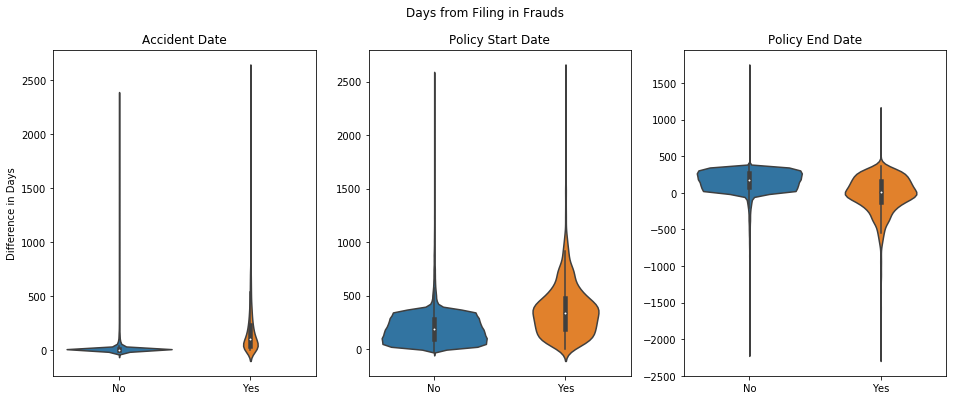

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(16, 6))
sns.violinplot(y='filing_diff', x='fraud', data=claims_ass, ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_ylabel('Difference in Days')
ax[0].set_xticklabels(['No', 'Yes'], rotation=0)
ax[0].set_title('Accident Date')

sns.violinplot(y='start_diff', x='fraud', data=claims_ass, ax=ax[1])
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_xticklabels(['No', 'Yes'], rotation=0)
ax[1].set_title('Policy Start Date')

sns.violinplot(y='end_diff', x='fraud', data=claims_ass, ax=ax[2])
ax[2].set_xlabel('')
ax[2].set_ylabel('')
ax[2].set_xticklabels(['No', 'Yes'], rotation=0)
ax[2].set_title('Policy End Date')

plt.suptitle('Days from Filing in Frauds');
# plt.savefig('../reports/figures/fraud_days.png')

Finally, I'll look into the money provisions, in particular the outgoing ones:

In [27]:
prov_ass = provisions.merge(assessments, how='inner', left_on='claim_code', right_on='claim_code')
prov_ass['fraud'] = prov_ass['company_score'].apply(lambda x: 1 if x > 50.0 else 0)

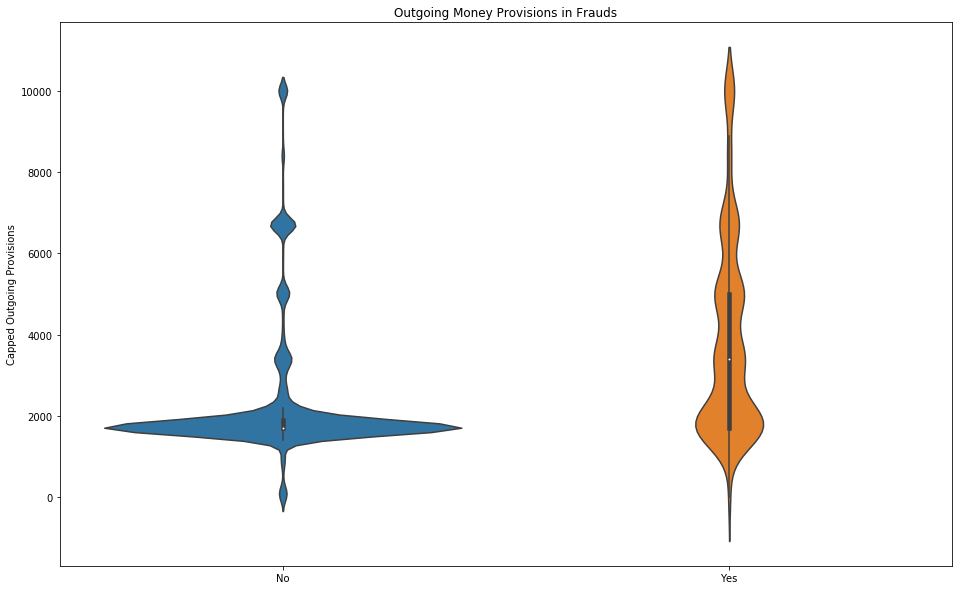

In [28]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.violinplot(y='capped_outgoing_provision', x='fraud', data=prov_ass, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Capped Outgoing Provisions')
ax.set_xticklabels(['No', 'Yes'], rotation=0)
ax.set_title('Outgoing Money Provisions in Frauds');
# plt.savefig('../reports/figures/fraud_provisions.png')

## Network Data

In this last part I'm going to create the network of involved parties in a claim: I'm using the data about car drivers and owners, linking two people if they have been in the same claim on opposite sides (i.e. if one of them is insured with the company and the other is a client of another company, called the counterpart).

In [29]:
network_raw = pd.read_csv('../data/raw/network.csv', sep=';')

In [30]:
network = network_raw.loc[network_raw['insured_counterpart']=='A'].copy()\
                    .merge(network_raw.loc[network_raw['insured_counterpart']=='C'],
                           how='inner', left_on='claim_code', right_on='claim_code', suffixes=['_lt', '_rt'])

network.drop(['ranking_lt', 'ranking_rt'], axis=1, inplace=True)

In [31]:
network.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106737 entries, 0 to 106736
Data columns (total 7 columns):
id_lt                     106737 non-null int64
role_lt                   106737 non-null object
insured_counterpart_lt    106737 non-null object
claim_code                106737 non-null int64
id_rt                     106737 non-null int64
role_rt                   106737 non-null object
insured_counterpart_rt    106737 non-null object
dtypes: int64(3), object(4)
memory usage: 6.5+ MB


For analyzing the network I'm creating a multigraph using `networkx`:

In [32]:
import networkx as nx

In [33]:
nw = nx.MultiGraph()
nw.add_edges_from(network[['id_lt', 'id_rt']].values);

In [34]:
print('Number of nodes: {}\nNumber of edges: {}\nNumber of connected components: {}'
      .format(nw.number_of_nodes(), nw.number_of_edges(), nx.number_connected_components(nw)))

Number of nodes: 176768
Number of edges: 106737
Number of connected components: 71990


I'm interested in identifying anomalous structures, in particular the cycles in the graph: I would say it is very strange to have two distinct car accidents with two people that have been in third car accident among them!

Firstly, I'm going to need a function to count the number of cycles for a node:

In [35]:
def calc_n_of_cycles(graph, start_node, end_node):
    n_of_paths = {}
    for i, node in enumerate(graph.nodes):
        if i < start_node:
            continue
        paths = list(nx.all_simple_paths(graph, node, node))
        paths = [p for p in paths if len(p) > 3 and len(p) == len(set(p))+1]
        temp_sub = []
        for p in paths:
            if set(p) not in temp_sub:
                temp_sub.append(set(p))

        n_of_paths[i] = [node, len(temp_sub)]
        if i >= end_node-1:
            break
    return pd.DataFrame.from_dict(n_of_paths, orient='index')

Then I'm using it to create a dataset containing the number of each node in the graph, saving the result in a pickle for future use.

In [36]:
all_cycles = pd.DataFrame()
for i in range(round(nw.number_of_nodes() / 50000)):
    temp = calc_n_of_cycles(nw, i*50000, (i+1)*50000)
    print(i)
    all_cycles = all_cycles.append(temp)

0
1
2
3


In [37]:
all_cycles.rename(columns={0:'id', 1:'n_cycles'}, inplace=True)

In [38]:
all_cycles.to_pickle('../data/interim/cycles.pkl')

In [39]:
all_cycles.sort_values(by='n_cycles', ascending=False).head()

,id,n_cycles
18030,147731,153
18027,114287,153
18029,96784,147
18028,152750,147
18034,47134,88


To exemplify the structures I'm interested in, here I create a function that finds the connected component a node is part of and one that finds all the claims related to the nodes in the component; I then plot some examples and the fraud scores of the related claims:

In [40]:
def find_neighbours(graph, start_node):
    nodes = set([])
    next_nodes = [start_node]
    prev_length = -1
    act_length = len(nodes)
    while act_length > prev_length:
        temp = []
        for node in next_nodes:
            neighbours = list(graph[node])
            for neigh in neighbours:
                if neigh not in nodes:
                    temp = temp + [neigh]
        nodes = nodes.union(set(temp))
        next_nodes = temp
        prev_length = act_length
        act_length = len(nodes)
    return list(nodes)

In [41]:
def find_claims(network, entity):
    claims = network.loc[(network['id_lt']==entity)|(network['id_rt']==entity)]
    return list(claims['claim_code'].unique())

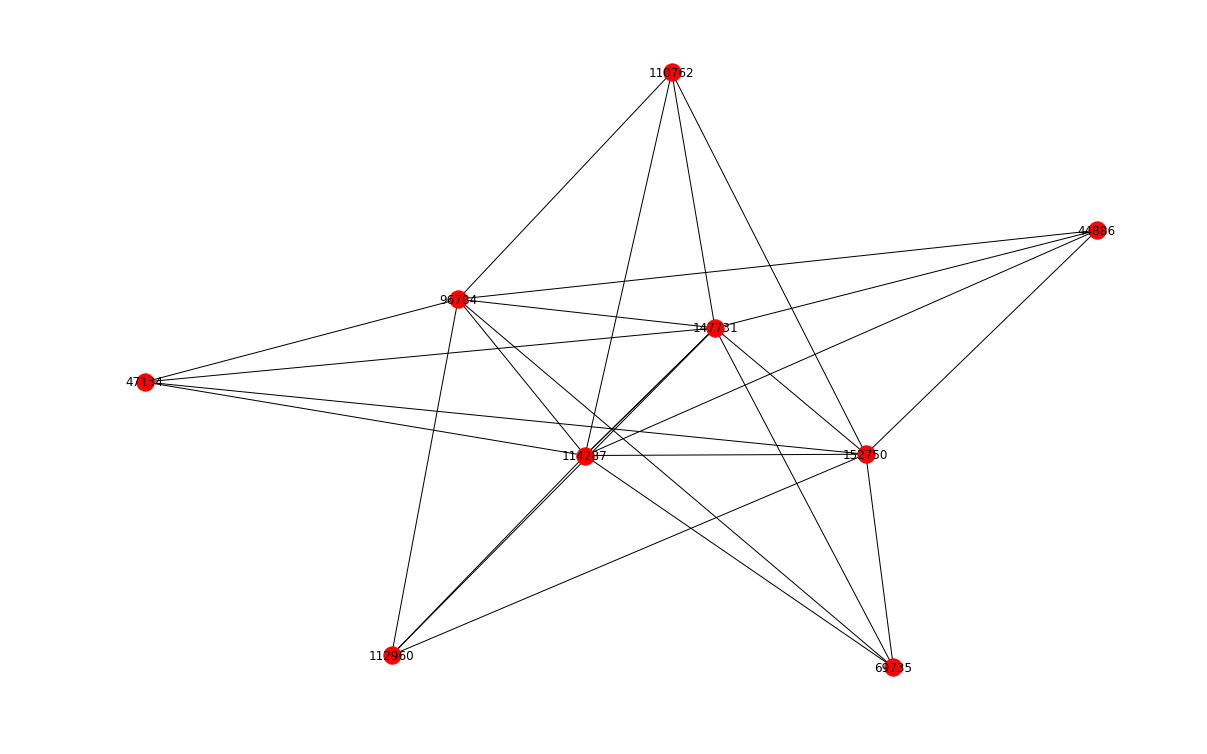

In [42]:
plt.figure(figsize=(16, 10))
nx.draw(nw.subgraph(find_neighbours(nw, 152750)), with_labels=True)
# plt.savefig('../reports/figures/graph.png')

In [43]:
clm = []
for cf in find_neighbours(nw, 152750):
    clm = clm + find_claims(network, cf)

assessments.loc[assessments['claim_code'].isin(list(set(clm)))]

,claim_code,company_score,ivass_score,fraud_evaluation
54252,2016010402355600,47.0,0.0,Frode probabile


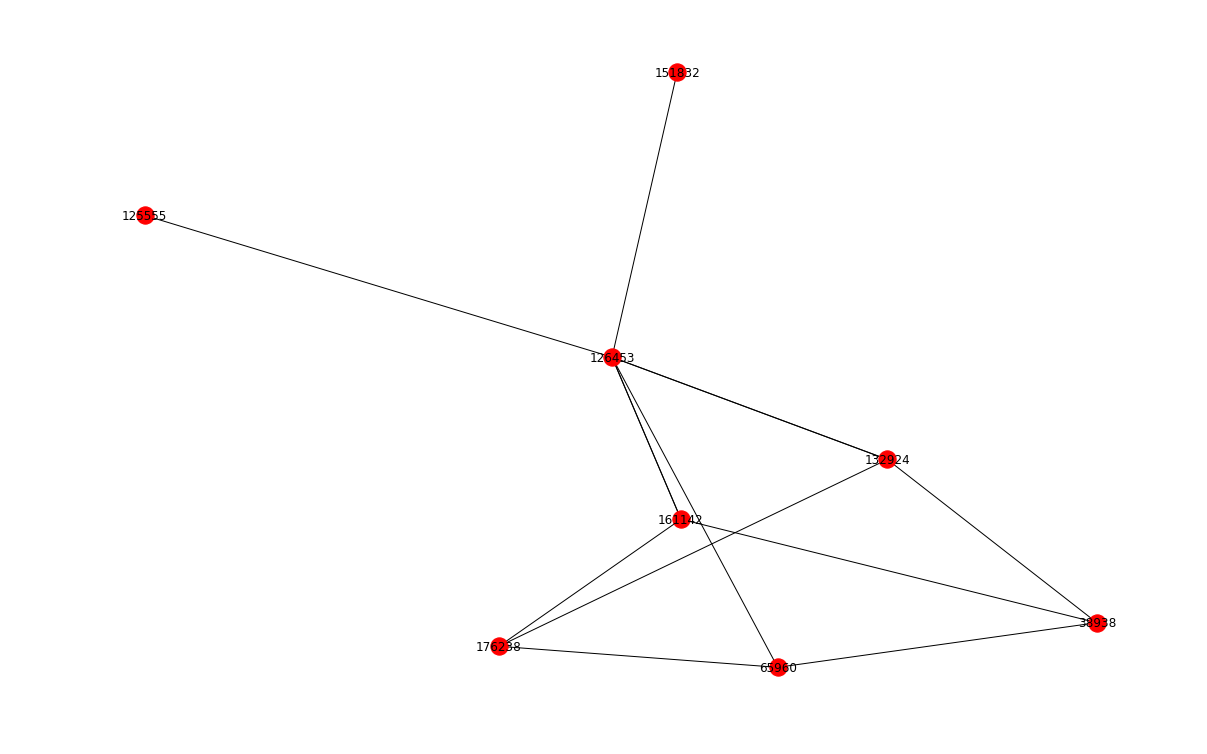

In [44]:
plt.figure(figsize=(16, 10))
nx.draw(nw.subgraph(find_neighbours(nw, 126453)), with_labels=True)

In [45]:
clm = []
for cf in find_neighbours(nw, 126453):
    clm = clm + find_claims(network, cf)

assessments.loc[assessments['claim_code'].isin(list(set(clm)))]

,claim_code,company_score,ivass_score,fraud_evaluation
20533,2014010600192300,38.0,40.0,NaN
21673,2014010630026800,19.0,40.0,NaN
21978,2014010600183400,33.0,40.0,NaN
36151,2015010402233300,23.0,40.0,NaN


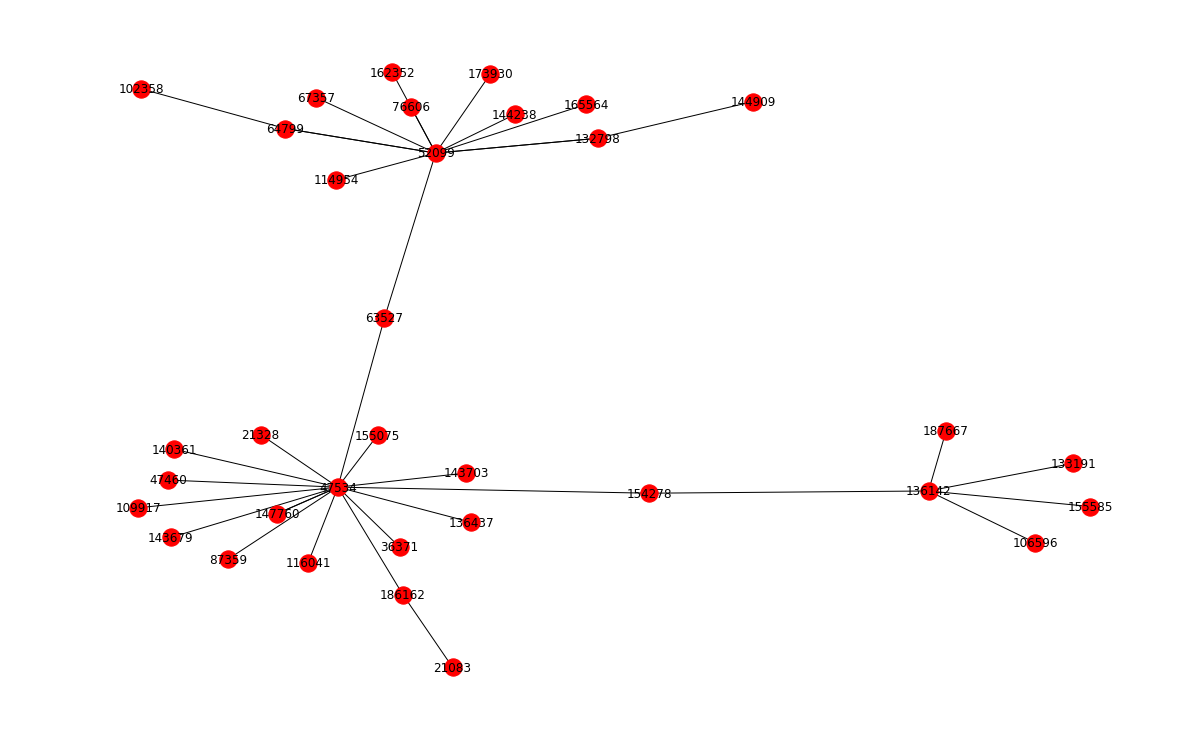

In [46]:
plt.figure(figsize=(16, 10))
nx.draw(nw.subgraph(find_neighbours(nw, 63527)), with_labels=True)

In [47]:
clm = []
for cf in find_neighbours(nw, 63527):
    clm = clm + find_claims(network, cf)

assessments.loc[assessments['claim_code'].isin(list(set(clm)))]

,claim_code,company_score,ivass_score,fraud_evaluation
21,2010010031011600,44.0,40.0,Frode acclarata
22,2010010031019400,54.0,60.0,Frode acclarata
135,2011010000003000,48.0,40.0,Frode acclarata
155,2010010000333600,52.0,60.0,Frode probabile
572,2011010031086000,2.0,0.0,NaN
919,2010010000401000,40.0,40.0,Frode acclarata
1207,2010010000332600,59.0,40.0,Frode acclarata
1208,2010010000343100,48.0,60.0,Frode acclarata
1209,2010010000376000,53.0,60.0,Frode acclarata
1729,2011010031025700,54.0,60.0,Frode acclarata


The first graph is due only to one (very complex) claim, which has a relatively high score. The second one, despite its apparent complexity, doesn't translate in claims with very high scores, while the last big component has a lot of claims with high scores which have been recognized as frauds also by ANIA.

This information, used in combination with some measure of centrality (such as the degree of a node) could produce a reliable score for the entities involved in a claim, which is what I'll be doing in the next notebook.

## Following Notebooks

- [Network Analysis](2.1-Network.ipynb)
- [Lawyers' Network Analysis](2.2-Network-Lawyers.ipynb)
- [Witnesses' Network Analysis](2.3-Network-Witnesses.ipynb)
- [Dataset Creation](3-Input_dataset_creation.ipynb)
- [Random Forest Prediction](4-Model.ipynb)